In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
df = pd.read_csv('../../data/swat/swat_ieee754.csv')

In [3]:
inputs = df.iloc[:, :-1]
labels = (df.iloc[:, -1])

In [4]:
counts = labels.value_counts()

In [5]:
from imblearn.over_sampling import SMOTE

#   创建SMOTE实例并指定少数类的过采样比例为2倍
smote = SMOTE(sampling_strategy={i: 500 for i in range(36)})

# 应用过采样
X_resampled, y_resampled = smote.fit_resample(inputs, labels)

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 397544 samples and 500 samples are asked.

In [6]:
counts = y_resampled.value_counts()

NameError: name 'y_resampled' is not defined

In [7]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [8]:
index = np.where(labels == 0)[0]
inputs_0 = inputs.values[index]

KNN

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(inputs_0)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=432)
kmeans.fit(X_scaled)
labels_0 = kmeans.labels_

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=labels_0)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
labels = labels + 5

In [ ]:
labels.loc[index] = labels_0

In [ ]:
combined_df = pd.concat([inputs, labels], axis=1)

In [ ]:
combined_df.to_csv('swat_ieee754_knn6.csv', index=False)

高斯混合聚类

In [9]:
from sklearn.mixture import GaussianMixture

# 设置聚类的数量
num_clusters = 5  # 根据需要调整

# 初始化和训练GMM
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(inputs_0)

# 获取聚类标签
cluster_labels = gmm.predict(inputs_0)

# 获取每个簇的概率
probabilities = gmm.predict_proba(inputs_0)


In [11]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(inputs_0, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")


KeyboardInterrupt: 

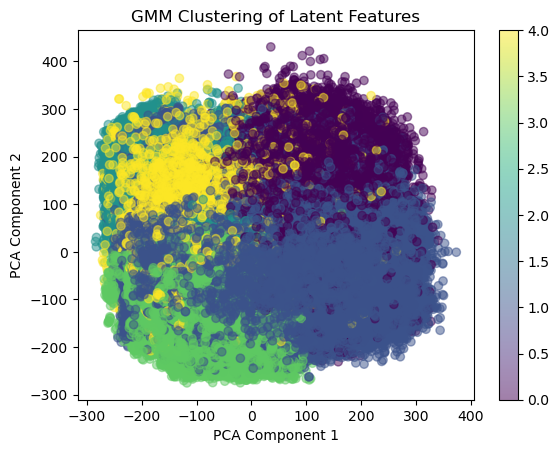

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 使用PCA降维到2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(inputs_0)

# 可视化
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('GMM Clustering of Latent Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [14]:
labels = labels + 5

In [15]:
labels.loc[index] = cluster_labels

In [16]:
combined_df = pd.concat([inputs, labels], axis=1)

In [17]:
combined_df.to_csv('swat_ieee754_gmm5.csv', index=False)

结合自动编码器和聚类

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# 假设data是一个numpy数组，形状为(num_samples, 127)
data = df.to_numpy()  # 加载SWaT数据集
data_tensor = torch.FloatTensor(data)  # 转换为PyTorch张量

# 创建数据加载器
batch_size = 32
train_dataset = TensorDataset(data_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 自动编码器定义
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(127, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)  # 潜在空间维度为16
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 127)  # 输出维度与输入相同
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [ ]:
# 初始化自动编码器和训练参数
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
num_epochs = 50  # 训练轮数

# 训练自动编码器
for epoch in range(num_epochs):
    for inputs in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(inputs[0])  # inputs是一个包含batch的元组
        loss = criterion(outputs, inputs[0])  # 计算重建损失
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 提取潜在特征
with torch.no_grad():
    latent_features = autoencoder.encoder(data_tensor).numpy()
